# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [9]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [10]:
#data_dir = 'data' 
data_dir = '/content/drive/MyDrive/data_classification'
os.listdir(data_dir)

['Positive', 'Negative']

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/drive/MyDrive/data_classification/Negative/U6.webp
Image not in ext list /content/drive/MyDrive/data_classification/Negative/U13.webp


# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
#data = tf.keras.utils.image_dataset_from_directory('data')
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data_classification', batch_size=12)



Found 140 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

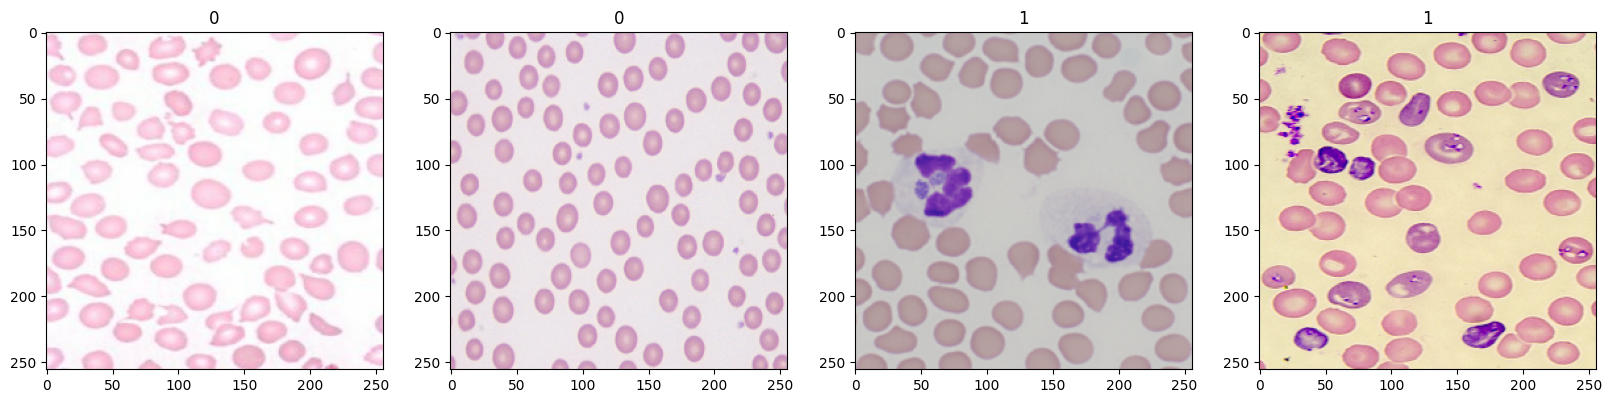

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))


In [20]:
len(data)

12

In [ ]:
data.as_numpy_iterator().next()

# 5. Split Data

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
test_size

1

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [27]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
8/8 [==============================] - 12s 1s/step - loss: 0.7698 - accuracy: 0.5833 - val_loss: 0.6817 - val_accuracy: 0.6250
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 0.6846 - accuracy: 0.5833 - val_loss: 0.5931 - val_accuracy: 0.7083
Epoch 3/20
8/8 [==============================] - 7s 785ms/step - loss: 0.6561 - accuracy: 0.5938 - val_loss: 0.5859 - val_accuracy: 0.5833
Epoch 4/20
8/8 [==============================] - 8s 871ms/step - loss: 0.5855 - accuracy: 0.6250 - val_loss: 0.5488 - val_accuracy: 0.6250
Epoch 5/20
8/8 [==============================] - 9s 1s/step - loss: 0.4941 - accuracy: 0.6667 - val_loss: 0.3292 - val_accuracy: 0.9167
Epoch 6/20
8/8 [==============================] - 8s 978ms/step - loss: 0.4440 - accuracy: 0.7292 - val_loss: 0.4456 - val_accuracy: 0.6250
Epoch 7/20
8/8 [==============================] - 7s 791ms/step - loss: 0.4302 - accuracy: 0.7812 - val_loss: 0.2800 - val_accuracy: 0.9583
Epoch 8/20
8/8 [============

# 8. Plot Performance

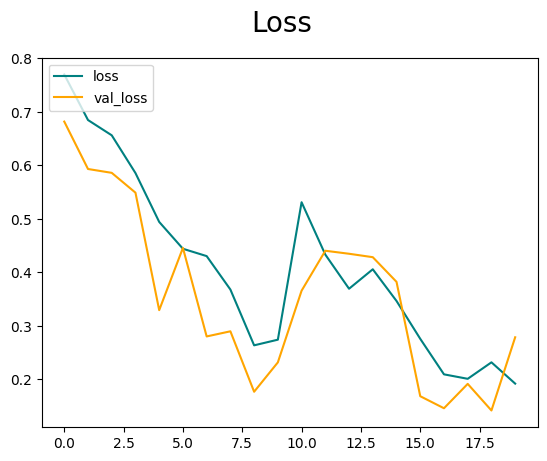

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

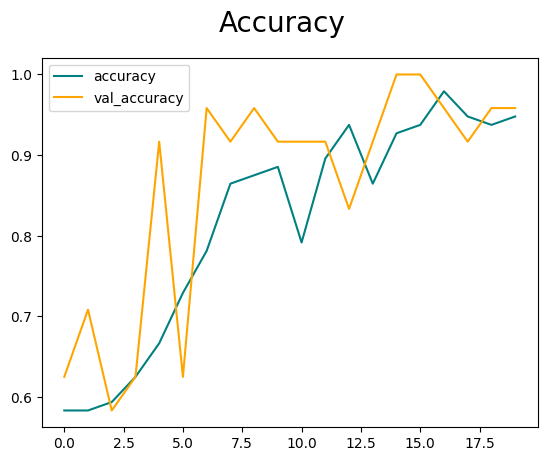

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
re = Recall()
acc = BinaryAccuracy()
pre = Precision()


In [40]:
len(test)

1

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 386ms/step


In [42]:
print(f'Precision:{pre.result().numpy()}, Recall ={re.result().numpy()}, Accuracy={acc.result()}')

Precision:1.0, Recall =0.800000011920929, Accuracy=0.9166666865348816


# 10. Test

In [43]:
import cv2

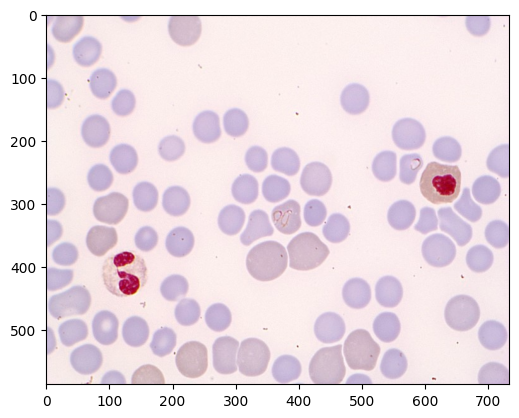

In [47]:
img = cv2.imread('/content/drive/MyDrive/data_classification/Positive/A10.jpg')
plt.imshow(img)
plt.show()

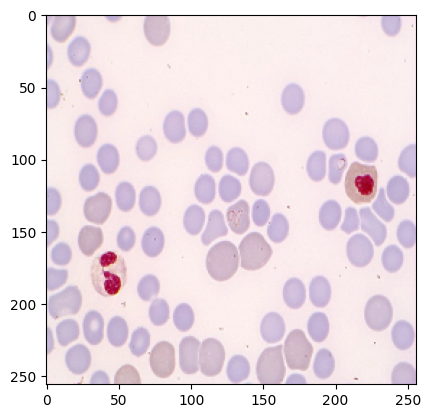

In [48]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [50]:
yhat

array([[0.99817646]], dtype=float32)

In [51]:
if yhat > 0.5: 
    print(f'Blood Sample has Haemoprotozoan infection')
else:
    print(f'Blood Sample is not infected')

Blood Sample has Haemoprotozoan infection


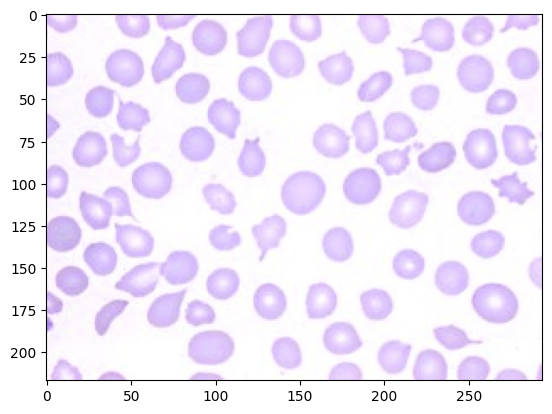

In [56]:
img = cv2.imread('/content/drive/MyDrive/data_classification/Negative/U1.jpg')
plt.imshow(img)
plt.show()

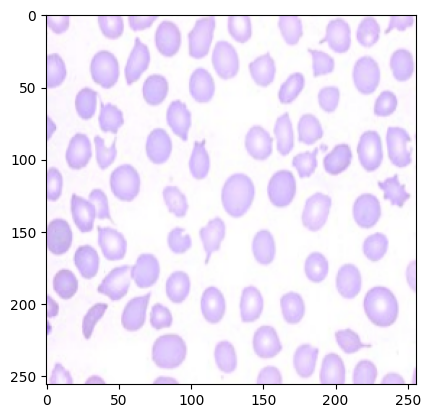

In [58]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 150ms/step


In [60]:
yhat

array([[0.349413]], dtype=float32)

In [61]:
if yhat > 0.5: 
    print(f'Blood Sample has Haemoprotozoan infection')
else:
    print(f'Blood Sample is not infected')

Blood Sample is not infected


# 11. Save the Model

In [52]:
from tensorflow.keras.models import load_model

In [53]:
model.save(os.path.join('models','imageclassifier.h5'))

In [54]:
new_model = load_model('models/imageclassifier.h5')

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 99ms/step


array([[0.99817646]], dtype=float32)